- RNN: Recurrent Neural Network
- LSTM: Long Short Term Memory
- ES: Early Stopping
- Multi-Step time series forecasting
- Multivariate (inputs Price and Volume)

In [37]:
# parameters
n_past_total = 1500 #2000
n_past = 120 #30 #50
prediction_days = 30 #10
activation = 'softsign' #'softsign' #'relu' #'sigmoid'
dropout = 0.2
n_neurons = 50
n_layers = 6 #hidden layers
n_features = 2
patience = 50

In [38]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
pd.set_option('display.float_format', lambda x: '%.3f' % x) #avoid scientific notation
np.set_printoptions(suppress=True)
import datetime
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from keras.callbacks import EarlyStopping
import seaborn as sns

In [39]:
# reading csv
dataset = pd.read_csv('yahoo_BTC-USD.csv')
dataset

Date      Open      High       Low     Close  Adj Close  \
0     2014-09-17   465.864   468.174   452.422   457.334    457.334   
1     2014-09-18   456.860   456.860   413.104   424.440    424.440   
2     2014-09-19   424.103   427.835   384.532   394.796    394.796   
3     2014-09-20   394.673   423.296   389.883   408.904    408.904   
4     2014-09-21   408.085   412.426   393.181   398.821    398.821   
...          ...       ...       ...       ...       ...        ...   
2449  2021-06-01 37293.793 37896.734 35787.086 36684.926  36684.926   
2450  2021-06-02 36699.922 38231.340 35966.309 37575.180  37575.180   
2451  2021-06-03 37599.410 39478.953 37243.973 39208.766  39208.766   
2452  2021-06-04 39242.484 39242.484 35717.723 36894.406  36894.406   
2453  2021-06-05 36780.348 37908.945 35548.820 35746.102  35746.102   

              Volume  
0       21056800.000  
1       34483200.000  
2       37919700.000  
3       36863600.000  
4       26580100.000  
...              ...  
2449 34639423297.000  
2450 33070867190.000  
2451 35460750427.000  
2452 41831090187.000  
2453 34500784128.000  

[2454 rows x 7 columns]

In [40]:
dataset[['Close','Volume']].corr()

Close  Volume
Close   1.000   0.798
Volume  0.798   1.000

In [41]:
# checking if close is not equal to adj close
dataset[dataset['Close']!=dataset['Adj Close']]

Date  Open  High  Low  Close  Adj Close  Volume
2039  2020-04-17   nan   nan  nan    nan        nan     nan
2214  2020-10-09   nan   nan  nan    nan        nan     nan
2217  2020-10-12   nan   nan  nan    nan        nan     nan
2218  2020-10-13   nan   nan  nan    nan        nan     nan

In [42]:
# checking for nulls
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2454 entries, 0 to 2453
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2454 non-null   object 
 1   Open       2450 non-null   float64
 2   High       2450 non-null   float64
 3   Low        2450 non-null   float64
 4   Close      2450 non-null   float64
 5   Adj Close  2450 non-null   float64
 6   Volume     2450 non-null   float64
dtypes: float64(6), object(1)
memory usage: 134.3+ KB


In [43]:
dataset.describe()

Open      High       Low     Close  Adj Close           Volume
count  2450.000  2450.000  2450.000  2450.000   2450.000         2450.000
mean   7626.843  7844.916  7387.271  7640.137   7640.137  12616231026.884
std   11665.490 12032.959 11232.481 11676.218  11676.218  19727883639.959
min     176.897   211.731   171.510   178.103    178.103      5914570.000
25%     460.801   466.735   455.070   460.719    460.719     68730922.000
50%    4324.400  4403.835  4138.012  4330.050   4330.050   4010640000.000
75%    9193.489  9355.582  9030.895  9203.736   9203.736  18684308124.500
max   63523.754 64863.098 62208.965 63503.457  63503.457 350967941479.000

In [44]:
# use close only and fill NaN with ffil
#n_past_total = 1500 #2000
df = dataset.set_index('Date')[['Close','Volume']].tail(n_past_total)
df = df.set_index(pd.to_datetime(df.index))
df.fillna(method='ffill',inplace=True)

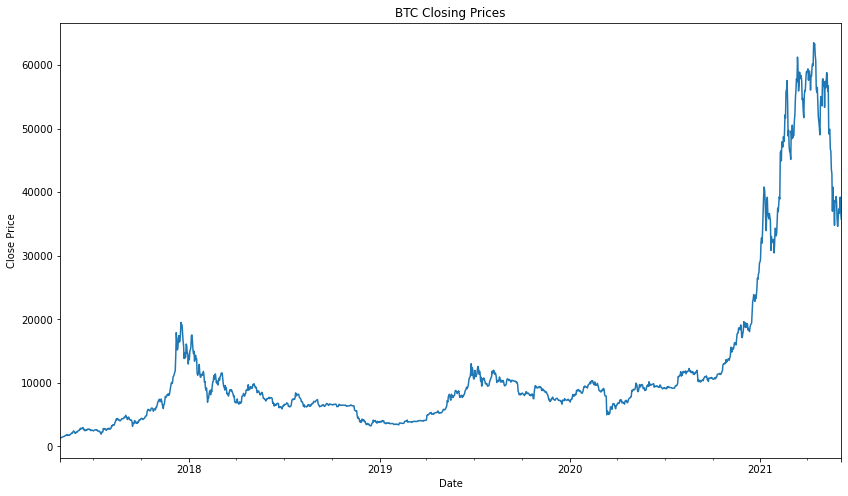

In [45]:
# plotting the Closing Prices
df['Close'].plot(figsize=(14,8))
plt.title('BTC Closing Prices')
plt.ylabel('Close Price')
plt.show()

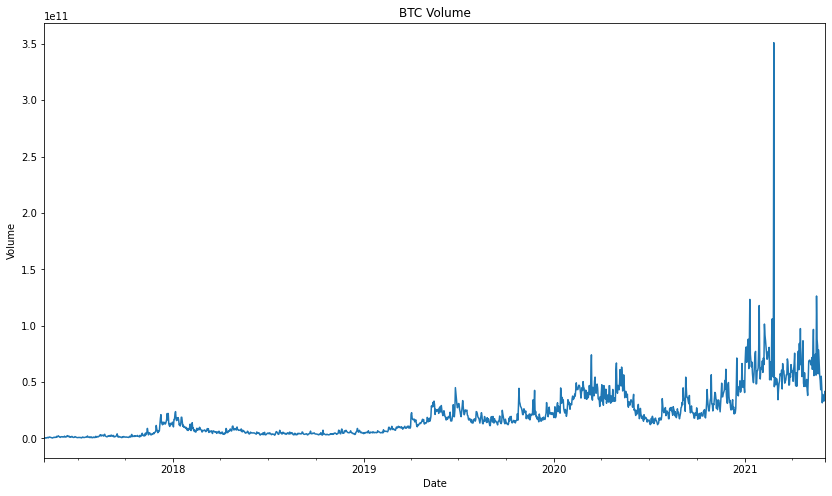

In [46]:
# plotting the Volume
df['Volume'].plot(figsize=(14,8))
plt.title('BTC Volume')
plt.ylabel('Volume')
plt.show()

In [47]:
# train test split
#prediction_days = 10
df_train = df.head(-prediction_days)
df_test = df.tail(prediction_days)
training_set = df_train.values
test_set = df_test.values
print('training_set.shape = ', training_set.shape)
print('test_set.shape = ', test_set.shape)

training_set.shape =  (1470, 2)
test_set.shape =  (30, 2)


In [48]:
# scale
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
print('training_set_scaled.shape', training_set_scaled.shape)
training_set_scaled

training_set_scaled.shape (1470, 2)


array([[0.        , 0.00032627],
       [0.00008539, 0.00002736],
       [0.00050509, 0.        ],
       ...,
       [0.83646226, 0.19441065],
       [0.90223919, 0.19634076],
       [0.88571656, 0.19714511]])

In [49]:
# creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
 
#n_future = prediction_days #20  # Number of days you want to predict into the future
#n_past = 50  # Number of past days you want to use to predict the future

for i in range(n_past, len(training_set_scaled) - prediction_days + 1):
    X_train.append(training_set_scaled[i-n_past:i, :])
    y_train.append(training_set_scaled[i:i+prediction_days, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [50]:
X_train.shape, y_train.shape

((1321, 120, 2), (1321, 30))

In [51]:
range(n_past, len(training_set_scaled) - prediction_days + 1)

range(120, 1441)

In [52]:
range(n_past, len(training_set_scaled)-7)

range(120, 1463)

In [53]:
for i in range(n_past, len(training_set_scaled) - prediction_days + 1):
    print('i={}, [{}, {})'.format(i, i-n_past, i))

i=120, [0, 120)
i=121, [1, 121)
i=122, [2, 122)
i=123, [3, 123)
i=124, [4, 124)
i=125, [5, 125)
i=126, [6, 126)
i=127, [7, 127)
i=128, [8, 128)
i=129, [9, 129)
i=130, [10, 130)
i=131, [11, 131)
i=132, [12, 132)
i=133, [13, 133)
i=134, [14, 134)
i=135, [15, 135)
i=136, [16, 136)
i=137, [17, 137)
i=138, [18, 138)
i=139, [19, 139)
i=140, [20, 140)
i=141, [21, 141)
i=142, [22, 142)
i=143, [23, 143)
i=144, [24, 144)
i=145, [25, 145)
i=146, [26, 146)
i=147, [27, 147)
i=148, [28, 148)
i=149, [29, 149)
i=150, [30, 150)
i=151, [31, 151)
i=152, [32, 152)
i=153, [33, 153)
i=154, [34, 154)
i=155, [35, 155)
i=156, [36, 156)
i=157, [37, 157)
i=158, [38, 158)
i=159, [39, 159)
i=160, [40, 160)
i=161, [41, 161)
i=162, [42, 162)
i=163, [43, 163)
i=164, [44, 164)
i=165, [45, 165)
i=166, [46, 166)
i=167, [47, 167)
i=168, [48, 168)
i=169, [49, 169)
i=170, [50, 170)
i=171, [51, 171)
i=172, [52, 172)
i=173, [53, 173)
i=174, [54, 174)
i=175, [55, 175)
i=176, [56, 176)
i=177, [57, 177)
i=178, [58, 178)
i=179, 

In [54]:
for i in range(n_past, len(training_set_scaled) - prediction_days + 1):
    print('i={}, [{}, {})'.format(i, i, i+prediction_days)) #  i,'-', i, '-', i+n_future)

i=120, [120, 150)
i=121, [121, 151)
i=122, [122, 152)
i=123, [123, 153)
i=124, [124, 154)
i=125, [125, 155)
i=126, [126, 156)
i=127, [127, 157)
i=128, [128, 158)
i=129, [129, 159)
i=130, [130, 160)
i=131, [131, 161)
i=132, [132, 162)
i=133, [133, 163)
i=134, [134, 164)
i=135, [135, 165)
i=136, [136, 166)
i=137, [137, 167)
i=138, [138, 168)
i=139, [139, 169)
i=140, [140, 170)
i=141, [141, 171)
i=142, [142, 172)
i=143, [143, 173)
i=144, [144, 174)
i=145, [145, 175)
i=146, [146, 176)
i=147, [147, 177)
i=148, [148, 178)
i=149, [149, 179)
i=150, [150, 180)
i=151, [151, 181)
i=152, [152, 182)
i=153, [153, 183)
i=154, [154, 184)
i=155, [155, 185)
i=156, [156, 186)
i=157, [157, 187)
i=158, [158, 188)
i=159, [159, 189)
i=160, [160, 190)
i=161, [161, 191)
i=162, [162, 192)
i=163, [163, 193)
i=164, [164, 194)
i=165, [165, 195)
i=166, [166, 196)
i=167, [167, 197)
i=168, [168, 198)
i=169, [169, 199)
i=170, [170, 200)
i=171, [171, 201)
i=172, [172, 202)
i=173, [173, 203)
i=174, [174, 204)
i=175, [17

i=855, [855, 885)
i=856, [856, 886)
i=857, [857, 887)
i=858, [858, 888)
i=859, [859, 889)
i=860, [860, 890)
i=861, [861, 891)
i=862, [862, 892)
i=863, [863, 893)
i=864, [864, 894)
i=865, [865, 895)
i=866, [866, 896)
i=867, [867, 897)
i=868, [868, 898)
i=869, [869, 899)
i=870, [870, 900)
i=871, [871, 901)
i=872, [872, 902)
i=873, [873, 903)
i=874, [874, 904)
i=875, [875, 905)
i=876, [876, 906)
i=877, [877, 907)
i=878, [878, 908)
i=879, [879, 909)
i=880, [880, 910)
i=881, [881, 911)
i=882, [882, 912)
i=883, [883, 913)
i=884, [884, 914)
i=885, [885, 915)
i=886, [886, 916)
i=887, [887, 917)
i=888, [888, 918)
i=889, [889, 919)
i=890, [890, 920)
i=891, [891, 921)
i=892, [892, 922)
i=893, [893, 923)
i=894, [894, 924)
i=895, [895, 925)
i=896, [896, 926)
i=897, [897, 927)
i=898, [898, 928)
i=899, [899, 929)
i=900, [900, 930)
i=901, [901, 931)
i=902, [902, 932)
i=903, [903, 933)
i=904, [904, 934)
i=905, [905, 935)
i=906, [906, 936)
i=907, [907, 937)
i=908, [908, 938)
i=909, [909, 939)
i=910, [91

In [55]:
# reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_features))
X_train.shape

(1321, 120, 2)

In [56]:
# building the RNN

# Initialising the RNN
regressor = Sequential()

regressor.add(LSTM(units=n_past, return_sequences=True, activation=activation, input_shape=(X_train.shape[1], n_features))) 
#regressor.add(LSTM(units=neurons, return_sequences=True, activation=activation, input_shape=(X_train.shape[1], 1))) 
#regressor.add(Dropout(dropout))

# Hidden layers
for _ in range(n_layers):
    regressor.add(LSTM(units=n_neurons, return_sequences=True, activation=activation))
    regressor.add(Dropout(dropout))

regressor.add(LSTM(units=n_neurons, return_sequences=False, activation=activation))
#regressor.add(Dropout(dropout))

# Adding the output layer
regressor.add(Dense(units=prediction_days))

# Compiling the RNN
regressor.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
#try also with RMSprop

# Model summary
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 120, 120)          59040     
_________________________________________________________________
lstm_9 (LSTM)                (None, 120, 50)           34200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 120, 50)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 120, 50)           20200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 120, 50)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 120, 50)           20200     
_________________________________________________________________
dropout_8 (Dropout)          (None, 120, 50)          

In [57]:
# including early stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
#early_stop = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=25)

In [58]:
'''
# validation_data
X_val = df['Close'][-n_past-prediction_days:-prediction_days].values.reshape(-1,1)
X_val = sc.transform(X_val)
X_val = X_val.reshape(-1,n_past,n_features)

# getting the true values
y_val = df['Close'][-prediction_days:].values
y_val = sc.transform(y_val.reshape(-1,1))
y_val = y_val.reshape(-1, 10, 1)
X_val.shape, y_val.shape
'''

"\n# validation_data\nX_val = df['Close'][-n_past-prediction_days:-prediction_days].values.reshape(-1,1)\nX_val = sc.transform(X_val)\nX_val = X_val.reshape(-1,n_past,n_features)\n\n# getting the true values\ny_val = df['Close'][-prediction_days:].values\ny_val = sc.transform(y_val.reshape(-1,1))\ny_val = y_val.reshape(-1, 10, 1)\nX_val.shape, y_val.shape\n"

In [ ]:
# Fitting the RNN to the Training set
res = regressor.fit(X_train, y_train
                    , batch_size=32
                    , epochs=500
                    #, validation_data=(X_val,y_val)
                    , validation_split=0.1
                    , callbacks=[early_stop]
                   ) 
# 100/32 / 250 , validation_split=0.1)
# the smaller the btach, the less overfitting, normally a number poewr of 2, 32,64,128, etc

Epoch 1/500
38/38 [==============================] - 20s 291ms/step - loss: 0.0083 - accuracy: 0.0256 - val_loss: 0.3586 - val_accuracy: 0.0902
Epoch 2/500
38/38 [==============================] - 10s 263ms/step - loss: 0.0023 - accuracy: 0.0296 - val_loss: 0.3160 - val_accuracy: 0.0150
Epoch 3/500
38/38 [==============================] - 9s 242ms/step - loss: 0.0020 - accuracy: 0.0351 - val_loss: 0.3143 - val_accuracy: 0.0150
Epoch 4/500
38/38 [==============================] - 9s 241ms/step - loss: 0.0018 - accuracy: 0.0574 - val_loss: 0.2879 - val_accuracy: 0.1053
Epoch 5/500
38/38 [==============================] - 9s 243ms/step - loss: 0.0016 - accuracy: 0.0479 - val_loss: 0.2971 - val_accuracy: 0.0376
Epoch 6/500
38/38 [==============================] - 10s 269ms/step - loss: 0.0015 - accuracy: 0.0700 - val_loss: 0.2529 - val_accuracy: 0.0150
Epoch 7/500
38/38 [==============================] - 11s 277ms/step - loss: 0.0013 - accuracy: 0.0695 - val_loss: 0.2469 - val_accuracy: 0.

In [ ]:
regressor.save('regressor.h5')

In [ ]:
list(res.history)

In [ ]:
# Plotting Accuracy and Loss

results = res

history = results.history
plt.figure(figsize=(12,4))
plt.plot(history['val_loss'])
plt.plot(history['loss'])
plt.legend(['val_loss', 'loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(12,4))
plt.plot(history['val_accuracy'])
plt.plot(history['accuracy'])
plt.legend(['val_accuracy', 'accuracy'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
def dummy_invscaler(y):
    '''
    Since the scaler was trained into 2 features, it needs two features to perform the inverse scaleer.
    For that purpose, this function will create a dummy array and concatenate it to the y_pred/y_true.
    That dummy of ones will be drop after performing the inverse_transform.
    INPUTS: array 'y', shape (X,)
    '''
    dummy = np.ones((len(y),1))
    y = np.array(y).reshape(-1,1)
    y = np.concatenate((y, dummy), axis=1)
    y = sc.inverse_transform(y)
    y = y[:,0]
    return y

In [ ]:
# Validation (validation with the last training days -> -15-15 DAYS)

# getting the predictions
y_pred = regressor.predict(X_train[-1].reshape(1, n_past, n_features)).tolist()[0]
#dummy = np.ones((len(y_pred),1))
#y_pred = np.array(y_pred).reshape(-1,1)
#y_pred = np.concatenate((y_pred, dummy), axis=1)
#y_pred = sc.inverse_transform(y_pred)#.tolist()
#y_pred = y_pred[:,0]
y_pred = dummy_invscaler(y_pred)
#y_pred = sc.inverse_transform(np.array(y_pred).reshape(-1,1))#.tolist()

# getting the true values
#y_true = y_train[-1].reshape(-1,1)
#y_true = np.concatenate((y_true, dummy), axis=1)
#y_true = sc.inverse_transform(y_true)
#y_true = y_true[:,0]
y_true = dummy_invscaler(y_train[-1])


print('y_pred:\n', y_pred.tolist())
print('y_true:\n', y_true.tolist())

# plotting the results
plt.figure(figsize=(16,5))
plt.plot(y_pred, label='Predicted')
plt.plot(y_true, label='True')

dates = df_train.index[-prediction_days:]
dates = [str(dates.date[i]) for i in range(len(dates))]
plt.xticks(range(prediction_days),dates)

plt.title('BTC price Predicted vs True')
plt.legend()
plt.show()

In [ ]:
# Validation 2 (on the TEST SET -15 days)

# getting the predictions
x = df[['Close','Volume']][-n_past-prediction_days:-prediction_days].values
x = sc.transform(x)
y_pred = regressor.predict(x.reshape(1, n_past, n_features)).tolist()[0]
#y_pred = sc.inverse_transform(np.array(y_pred).reshape(-1,1))#.tolist()
y_pred = dummy_invscaler(y_pred)

# getting the true values
y_true = df['Close'][-prediction_days:].values

print('y_pred:\n', y_pred.tolist())
print('y_true:\n', y_true.tolist())

# plotting the results
plt.figure(figsize=(16,5))
plt.plot(y_pred, label='Predicted')
plt.plot(y_true, label='True')

dates = df.index[-prediction_days:]
dates = [str(dates.date[i]) for i in range(len(dates))]
plt.xticks(range(prediction_days),dates)

plt.title('BTC price Predicted vs True')
plt.legend()
plt.show()

In [ ]:
# evaluation
rmse = math.sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
mean_absolute_error(y_true, y_pred)

In [ ]:
explained_variance_score(y_true, y_pred)
# Best possible score is 1.0, lower values are worse.

In [ ]:
# Forecasting/Predicting

# getting the predictions
x = df[['Close','Volume']][-n_past:].values
x = sc.transform(x)
y_pred = regressor.predict(x.reshape(1, n_past, n_features)).tolist()[0]
#y_pred = sc.inverse_transform(np.array(y_pred).reshape(-1,1))#.tolist()
y_pred = dummy_invscaler(y_pred)

# creating a DF of the predicted prices
y_pred_df = pd.DataFrame(y_pred, 
                         index=pd.date_range(start=df[['Close']].index[-1]+datetime.timedelta(days=1),
                                             periods=len(y_pred), 
                                             freq="D"), 
                         columns=df[['Close']].columns)

# getting the true values
y_true_df = df[['Close']].tail(prediction_days)

# linking them
y_true_df = y_true_df.append(y_pred_df.head(1))

print('y_pred:\n', y_pred.tolist())
print('y_true:\n', y_true.tolist())

# plotting the results
plt.figure(figsize=(12,5))
plt.plot(y_pred_df, label='Predicted')
plt.plot(y_true_df, label='True')

#dates = df.index[-prediction_days:]
#dates = [str(dates.date[i]) for i in range(len(dates))]
#plt.xticks(range(prediction_days),dates)

plt.title('BTC price Predicted vs True')
plt.legend()
plt.show()

In [ ]:
regressor.save('regressor.h5')
#loaded_regressor = load_model('regressor.h5')
#loaded_regressor.predict(new_x)

**Improving the RNN**

Here are different ways to improve the RNN model:

Getting more training data: we trained our model on the past 5 years of the Google Stock Price but it would be even better to train it on the past 10 years.

Increasing the number of timesteps: the model remembered the stock prices from the 60 previous financial days to predict the stock price of the next day. That’s because we chose a number of 60 timesteps (3 months). You could try to increase the number of timesteps, by choosing for example 120 timesteps (6 months).

Adding some other indicators: if you have the financial instinct that the stock price of some other companies might be correlated to the one of Google, you could add this other stock price as a new indicator in the training data.

Adding more LSTM layers: we built a RNN with four LSTM layers but you could try with even more.

Adding more neurones in the LSTM layers: we highlighted the fact that we needed a high number of neurones in the LSTM layers to respond better to the complexity of the problem and we chose to include 50 neurones in each of our 4 LSTM layers. You could try an architecture with even more neurones in each of the 4 (or more) LSTM layers.

**Evaluating the RNN**

As seen in the practical lectures, the RNN we built was a regressor. Indeed, we were dealing with Regression because we were trying to predict a continuous outcome (the Google Stock Price). For Regression, the way to evaluate the model performance is with a metric called RMSE (Root Mean Squared Error). It is calculated as the root of the mean of the squared differences between the predictions and the real values.

However for our specific Stock Price Prediction problem, evaluating the model with the RMSE does not make much sense, since we are more interested in the directions taken by our predictions, rather than the closeness of their values to the real stock price. We want to check if our predictions follow the same directions as the real stock price and we don’t really care whether our predictions are close the real stock price. The predictions could indeed be close but often taking the opposite direction from the real stock price.

Nevertheless if you are interested in the code that computes the RMSE for our Stock Price Prediction problem, please find it just below:

import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
Then consider dividing this RMSE by the range of the Google Stock Price values of January 2017 (that is around 800) to get a relative error, as opposed to an absolute error. It is more relevant since for example if you get an RMSE of 50, then this error would be very big if the stock price values ranged around 100, but it would be very small if the stock price values ranged around 10000.

Enjoy Deep Learning!